In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train_file_path = r"C:\Users\tsyas\projj\E-MTAB-11349\ArrayExpress-normalized.csv"
metadata_file_path = r"C:\Users\tsyas\projj\E-MTAB-11349\E-MTAB-11349.sdrf.txt"

def process_gene_expression_data(file_path, metadata_path):
    matrix = pd.read_csv(file_path)
    
    matrix = matrix.set_index('gene')
    matrix = matrix.T
    
    processed_data = pd.DataFrame(matrix)
    
    features_df = pd.read_csv(metadata_path, sep='\t', index_col=0)
    
    return processed_data, features_df

train_data, train_features = process_gene_expression_data(train_file_path, metadata_file_path)


In [5]:
train_data_cleaned = train_data.drop(['Unnamed: 0', 'refseq'], errors='ignore')

train_data_cleaned.index.name = 'Source Name'

train_data_cleaned

gene,ACADS,ACADVL,ACAT1,PSEN1,ADA,ADRB2,ADRB3,ADSL,AGA,ALAD,...,ALOX12-AS1,CYP21A1P,LOC100506990,LOC100506123,LINC01721,PCAT19,ANKRD20A5P,LINC00547,LINC00941,LINC00700
Source Name,,,,,,,,,,,,,,,,,,,,,
Sample 1,71.394731,202.285072,51.923441,1502.534571,155.770323,236.900699,4.326953,283.415448,122.236434,257.453728,...,493.2727,18.38955,100.6017,188.2225,3.245215,33.53389,23.79824,0.0,175.2416,55.16866
Sample 2,104.829005,308.215194,71.677952,1245.404416,215.033856,267.000371,6.271821,268.79232,120.956544,275.960115,...,422.8999,42.1108,68.09405,225.7855,8.959744,27.77521,13.43962,1.791949,116.4767,42.1108
Sample 3,173.466488,271.920441,80.87289,930.624269,257.855591,470.000418,16.408992,350.449189,134.78815,364.51404,...,307.0826,4.688283,104.3143,294.1898,5.860354,21.09728,39.85041,2.344142,80.87289,26.95763
Sample 4,103.796604,232.756022,80.992805,754.098056,247.696442,394.741631,6.290703,419.118106,61.334357,319.253192,...,392.3826,3.93169,69.19774,379.8012,7.077041,38.53056,18.87211,0.786338,99.07858,40.10323
Sample 5,83.472519,219.115362,57.861632,1089.885502,145.128357,181.173308,11.382616,315.8676,113.826162,239.983492,...,352.8611,128.0544,115.7233,518.8576,48.37612,129.9515,29.40509,36.9935,350.0154,207.7327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample 586,147.529335,278.935246,71.74924,1035.123862,216.860061,388.574534,11.286397,366.80791,112.863972,274.098219,...,336.1734,12.89874,80.61712,232.9835,4.837027,24.99131,24.99131,4.030856,91.09735,42.72708
Sample 587,94.187393,306.109028,53.515564,1343.240664,172.320117,187.304475,6.421868,278.280934,126.296732,323.234008,...,325.3746,5.351556,96.32802,180.8826,3.210934,34.24996,11.77342,8.56249,107.0311,62.07805
Sample 588,87.027568,230.201954,45.853235,2358.166354,111.357856,363.082756,10.293583,320.036862,79.541325,230.201954,...,417.358,10.29358,78.60555,126.3303,6.550462,33.68809,4.678901,2.807341,174.9909,46.78901


In [6]:
columns_to_keep = ['Characteristics[age]', 'Characteristics[sex]', 'Characteristics[disease]']
filtered_train_features = train_features[columns_to_keep]
filtered_train_features = filtered_train_features.rename(columns={
    'Characteristics[age]': 'Age',
    'Characteristics[sex]': 'Sex',
    'Characteristics[disease]': 'Disease'
})

disease_mapping = {
    'normal': 0,
    "Crohn's disease": 1,
    'ulcerative colitis': 2
}

filtered_train_features['Disease_Label'] = filtered_train_features['Disease'].map(disease_mapping)

filtered_train_features

,Age,Sex,Disease,Disease_Label
Source Name,,,,
Sample 1,34,male,Crohn's disease,1
Sample 2,49,female,normal,0
Sample 3,27,male,normal,0
Sample 4,9,male,normal,0
Sample 5,34,female,normal,0
...,...,...,...,...
Sample 586,25,male,Crohn's disease,1
Sample 587,44,male,normal,0
Sample 588,36,female,Crohn's disease,1


In [7]:
print("Indices match:", all(train_data_cleaned.index == filtered_train_features.index))

merged_data = train_data_cleaned.merge(filtered_train_features, left_index=True, right_index=True)

merged_data


Indices match: True


,ACADS,ACADVL,ACAT1,PSEN1,ADA,ADRB2,ADRB3,ADSL,AGA,ALAD,...,LINC01721,PCAT19,ANKRD20A5P,LINC00547,LINC00941,LINC00700,Age,Sex,Disease,Disease_Label
Source Name,,,,,,,,,,,,,,,,,,,,,
Sample 1,71.394731,202.285072,51.923441,1502.534571,155.770323,236.900699,4.326953,283.415448,122.236434,257.453728,...,3.245215,33.53389,23.79824,0.0,175.2416,55.16866,34,male,Crohn's disease,1
Sample 2,104.829005,308.215194,71.677952,1245.404416,215.033856,267.000371,6.271821,268.79232,120.956544,275.960115,...,8.959744,27.77521,13.43962,1.791949,116.4767,42.1108,49,female,normal,0
Sample 3,173.466488,271.920441,80.87289,930.624269,257.855591,470.000418,16.408992,350.449189,134.78815,364.51404,...,5.860354,21.09728,39.85041,2.344142,80.87289,26.95763,27,male,normal,0
Sample 4,103.796604,232.756022,80.992805,754.098056,247.696442,394.741631,6.290703,419.118106,61.334357,319.253192,...,7.077041,38.53056,18.87211,0.786338,99.07858,40.10323,9,male,normal,0
Sample 5,83.472519,219.115362,57.861632,1089.885502,145.128357,181.173308,11.382616,315.8676,113.826162,239.983492,...,48.37612,129.9515,29.40509,36.9935,350.0154,207.7327,34,female,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample 586,147.529335,278.935246,71.74924,1035.123862,216.860061,388.574534,11.286397,366.80791,112.863972,274.098219,...,4.837027,24.99131,24.99131,4.030856,91.09735,42.72708,25,male,Crohn's disease,1
Sample 587,94.187393,306.109028,53.515564,1343.240664,172.320117,187.304475,6.421868,278.280934,126.296732,323.234008,...,3.210934,34.24996,11.77342,8.56249,107.0311,62.07805,44,male,normal,0
Sample 588,87.027568,230.201954,45.853235,2358.166354,111.357856,363.082756,10.293583,320.036862,79.541325,230.201954,...,6.550462,33.68809,4.678901,2.807341,174.9909,46.78901,36,female,Crohn's disease,1


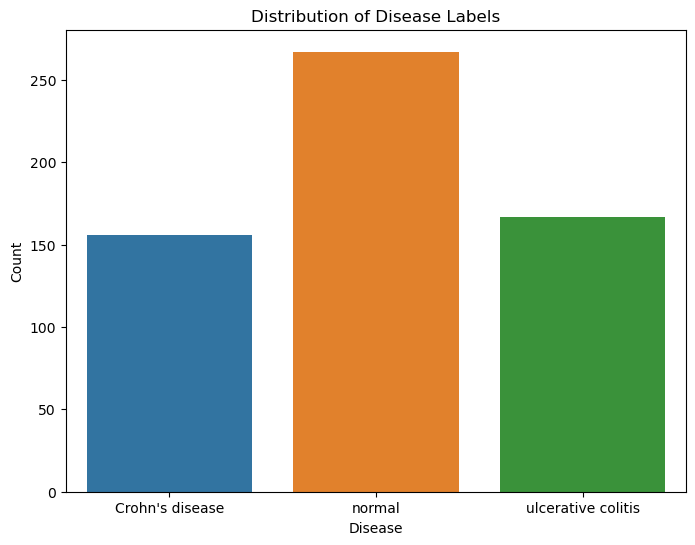

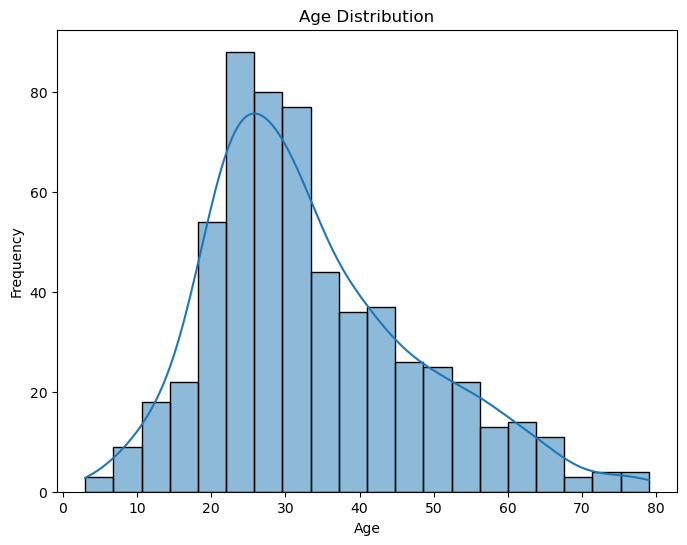

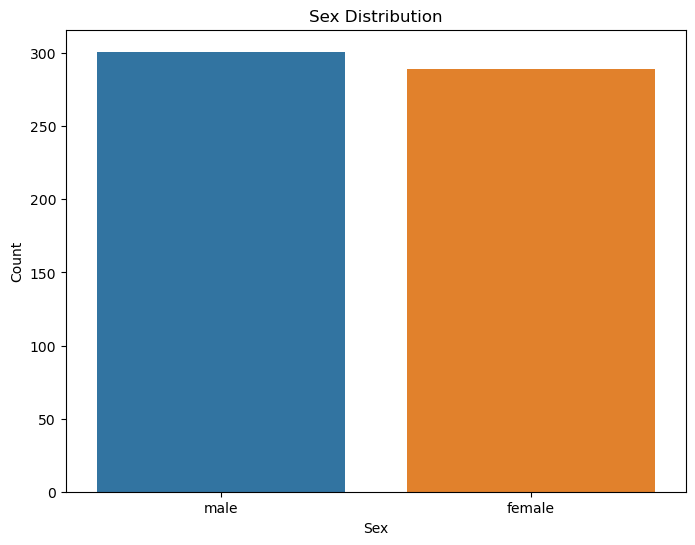

In [8]:
plt.figure(figsize=(8,6))
sns.countplot(x='Disease', data=filtered_train_features)
plt.title('Distribution of Disease Labels')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(filtered_train_features['Age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,6))
sns.countplot(x='Sex', data=filtered_train_features)
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()



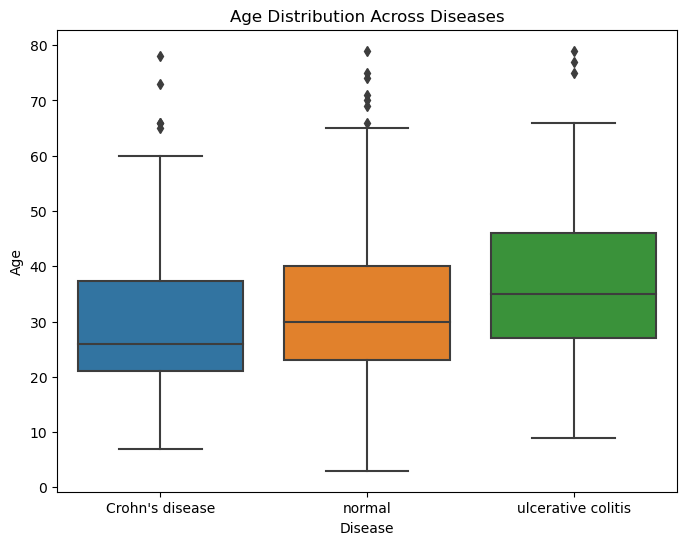

In [9]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Disease', y='Age', data=filtered_train_features)
plt.title('Age Distribution Across Diseases')
plt.xlabel('Disease')
plt.ylabel('Age')
plt.show()

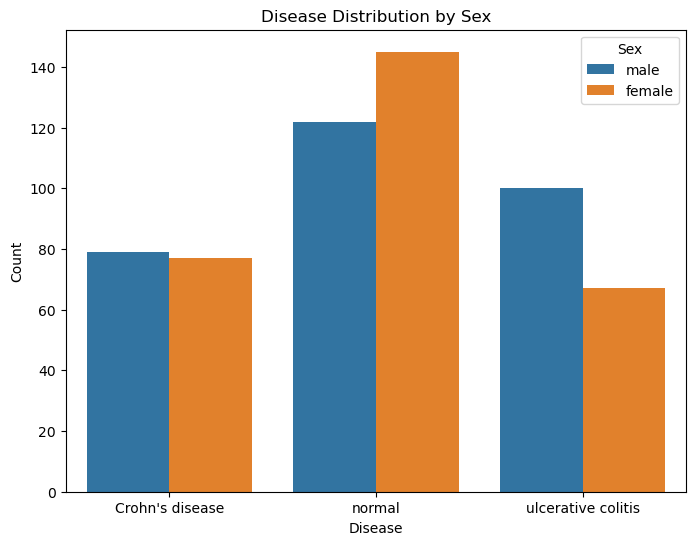

In [10]:
plt.figure(figsize=(8,6))
sns.countplot(x='Disease', hue='Sex', data=filtered_train_features)
plt.title('Disease Distribution by Sex')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.show()

In [11]:
X = merged_data.drop(columns=['Age', 'Sex', 'Disease', 'Disease_Label'])
y = merged_data['Disease_Label']

In [12]:
X.columns = X.columns.astype(str)

X = X.apply(pd.to_numeric, errors='coerce')

non_numeric_columns = X.columns[X.dtypes == 'object']
print("Non-numeric columns:", list(non_numeric_columns))

Non-numeric columns: []


In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.0)  

X_selected = selector.fit_transform(X_scaled)

selected_features = X.columns[selector.get_support(indices=True)]
print("Number of features after variance threshold:", len(selected_features))


Number of features after variance threshold: 14182


In [15]:
from sklearn.feature_selection import SelectKBest, f_classif

k = 500  
selector = SelectKBest(score_func=f_classif, k=k)

X_selected = selector.fit_transform(X_scaled, y)

selected_features = X.columns[selector.get_support(indices=True)]
print("Selected top {} features.".format(k))


Selected top 500 features.


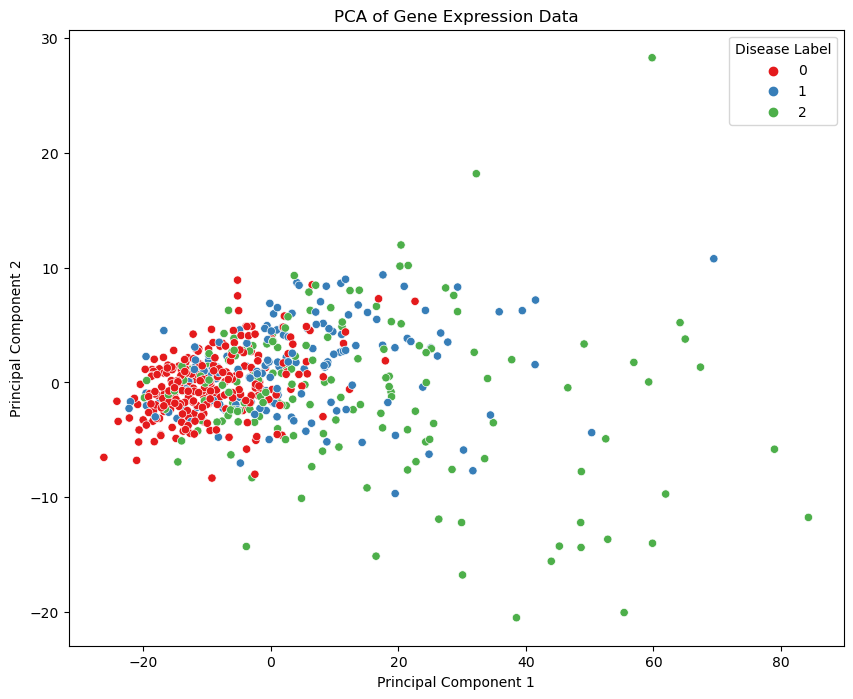

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_selected)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Disease_Label'] = y.values

plt.figure(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', hue='Disease_Label', data=pca_df, palette='Set1')
plt.title('PCA of Gene Expression Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Disease Label')
plt.show()


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y)


In [18]:
logreg = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=5000)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(logreg, X_train, y_train, cv=cv, scoring='accuracy', return_train_score=True)

print("Logistic Regression CV Training Accuracy:", cv_results['train_score'].mean())
print("Logistic Regression CV Validation Accuracy:", cv_results['test_score'].mean())

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Test Accuracy:", test_accuracy)

print("Classification Report:\n", classification_report(y_test, y_pred))


Logistic Regression CV Training Accuracy: 0.9788177339901477
Logistic Regression CV Validation Accuracy: 0.5997088465845465
Logistic Regression Test Accuracy: 0.6186440677966102
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.74      0.72        53
           1       0.53      0.55      0.54        31
           2       0.57      0.50      0.53        34

    accuracy                           0.62       118
   macro avg       0.60      0.59      0.60       118
weighted avg       0.62      0.62      0.62       118



In [19]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

cv_results = cross_validate(rfc, X_train, y_train, cv=cv, scoring='accuracy', return_train_score=True)

print("Random Forest CV Training Accuracy:", cv_results['train_score'].mean())
print("Random Forest CV Validation Accuracy:", cv_results['test_score'].mean())

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Test Accuracy:", test_accuracy)

print("Classification Report:\n", classification_report(y_test, y_pred))


Random Forest CV Training Accuracy: 1.0
Random Forest CV Validation Accuracy: 0.6251735722284435
Random Forest Test Accuracy: 0.6440677966101694
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.83      0.78        53
           1       0.49      0.55      0.52        31
           2       0.65      0.44      0.53        34

    accuracy                           0.64       118
   macro avg       0.62      0.61      0.61       118
weighted avg       0.64      0.64      0.64       118



In [20]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', probability=True, random_state=42)

cv_results = cross_validate(svm, X_train, y_train, cv=cv, scoring='accuracy', return_train_score=True)

print("SVM CV Training Accuracy:", cv_results['train_score'].mean())
print("SVM CV Validation Accuracy:", cv_results['test_score'].mean())

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("SVM Test Accuracy:", test_accuracy)

print("Classification Report:\n", classification_report(y_test, y_pred))


SVM CV Training Accuracy: 1.0
SVM CV Validation Accuracy: 0.5635834266517357
SVM Test Accuracy: 0.6440677966101694
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.74      0.72        53
           1       0.55      0.58      0.56        31
           2       0.63      0.56      0.59        34

    accuracy                           0.64       118
   macro avg       0.63      0.63      0.63       118
weighted avg       0.64      0.64      0.64       118



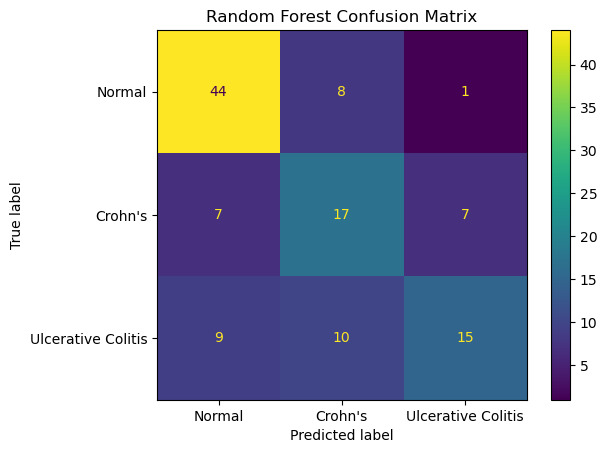

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(rfc, X_test, y_test, display_labels=['Normal', 'Crohn\'s', 'Ulcerative Colitis'])
plt.title('Random Forest Confusion Matrix')
plt.show()


        Gene  Importance
86   SLC26A8    0.022216
190    ANXA3    0.016244
381  GALNT14    0.015020
494  FCGR1CP    0.014647
140    SRPK1    0.012246
142     TLR5    0.010904
8       IL4R    0.009245
95     CASP4    0.008719
93   CACNA1E    0.008091
468   MCEMP1    0.008007
247   SLC2A3    0.007796
398  KREMEN1    0.007624
114      HK3    0.007318
205  S100A12    0.007138
171     NAIP    0.006671
423     MSL3    0.006140
459   ADGRG3    0.006044
183   VPS9D1    0.005789
238    PHTF1    0.005784
38    FCGR1B    0.005713


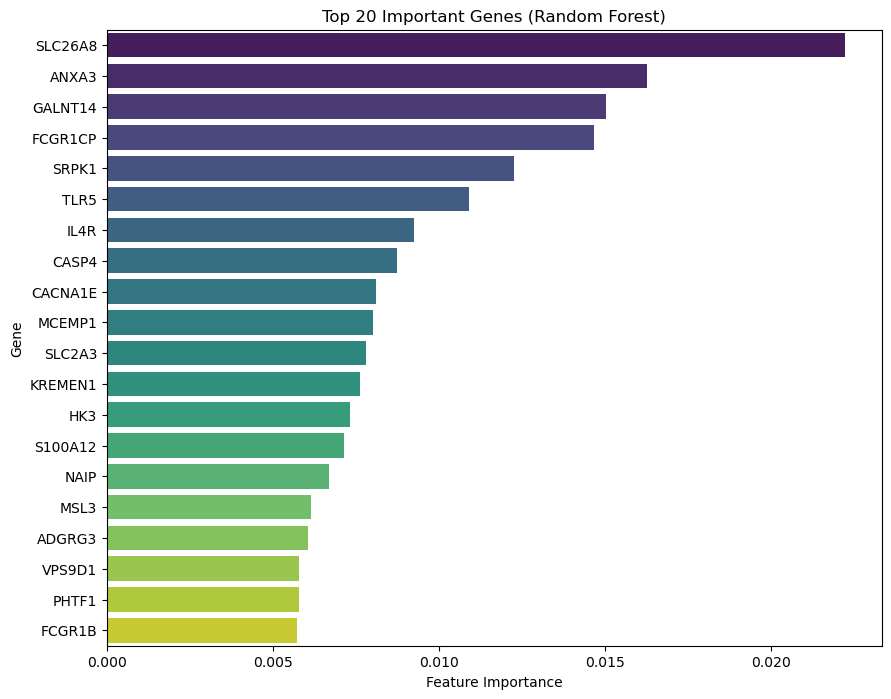

In [22]:
importances = rfc.feature_importances_

feature_importances = pd.DataFrame({
    'Gene': selected_features,
    'Importance': importances
})

feature_importances = feature_importances.sort_values('Importance', ascending=False)

top_genes_rfc = feature_importances.head(20)
print(top_genes_rfc)

plt.figure(figsize=(10,8))
sns.barplot(x='Importance', y='Gene', data=top_genes_rfc, palette='viridis')
plt.title('Top 20 Important Genes (Random Forest)')
plt.xlabel('Feature Importance')
plt.ylabel('Gene')
plt.show()


         Gene  Coefficient
248    STXBP2     1.280181
227   ST3GAL4     1.197487
8        IL4R     1.052225
65     EIF4E3     1.043168
281    LPGAT1     1.042029
3         HK2     0.999822
4       ITGB4     0.998549
417     PGAP3     0.992552
276   SLC40A1     0.876926
371    ANAPC1     0.859758
384     MCTP1     0.835594
208     ARL4C     0.833810
352     APMAP     0.830234
98   ATP6V1C1     0.818191
480      BBS9     0.813797
250    PICALM     0.812277
62      ATXN1     0.812069
86    SLC26A8     0.802909
37    CARMIL2     0.796937
377    LILRA6     0.792028


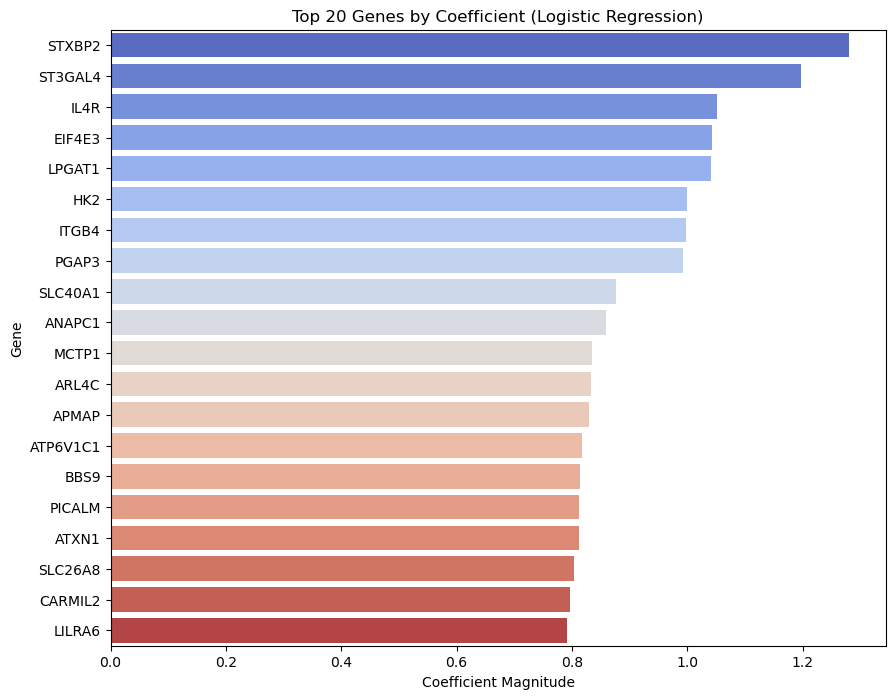

In [23]:
coefficients = logreg.coef_

coefficients_sum = np.sum(np.abs(coefficients), axis=0)

coef_df = pd.DataFrame({
    'Gene': selected_features,
    'Coefficient': coefficients_sum
})

coef_df = coef_df.sort_values('Coefficient', ascending=False)

top_genes_logreg = coef_df.head(20)
print(top_genes_logreg)

plt.figure(figsize=(10,8))
sns.barplot(x='Coefficient', y='Gene', data=top_genes_logreg, palette='coolwarm')
plt.title('Top 20 Genes by Coefficient (Logistic Regression)')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Gene')
plt.show()


In [24]:
merged_data['Sex_Encoded'] = merged_data['Sex'].map({'male': 0, 'female': 1})

additional_features = merged_data[['Age', 'Sex_Encoded']].values

X_with_aux = np.hstack((X_selected, additional_features))

aux_feature_names = ['Age', 'Sex_Encoded']
all_feature_names = list(selected_features) + aux_feature_names


In [25]:
X_train_aux, X_test_aux, y_train_aux, y_test_aux = train_test_split(
    X_with_aux, y, test_size=0.2, random_state=42, stratify=y)

rfc_aux = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_aux.fit(X_train_aux, y_train_aux)

y_pred_aux = rfc_aux.predict(X_test_aux)
test_accuracy_aux = accuracy_score(y_test_aux, y_pred_aux)
print("Random Forest with Age and Sex Test Accuracy:", test_accuracy_aux)

print("Improvement in accuracy:", test_accuracy_aux - test_accuracy)


Random Forest with Age and Sex Test Accuracy: 0.6440677966101694
Improvement in accuracy: 0.0


     Feature  Importance
190    ANXA3    0.015148
142     TLR5    0.012303
86   SLC26A8    0.011077
494  FCGR1CP    0.009929
38    FCGR1B    0.009553
146     CST7    0.009385
140    SRPK1    0.009317
93   CACNA1E    0.008751
398  KREMEN1    0.008125
8       IL4R    0.007566
423     MSL3    0.007195
71    ZNF438    0.007098
128   MAP2K6    0.007013
114      HK3    0.006990
1         F5    0.006901
458   KCNJ15    0.006711
439   MAPK14    0.006698
492    MGAM2    0.006653
171     NAIP    0.006321
366   LILRA5    0.006055


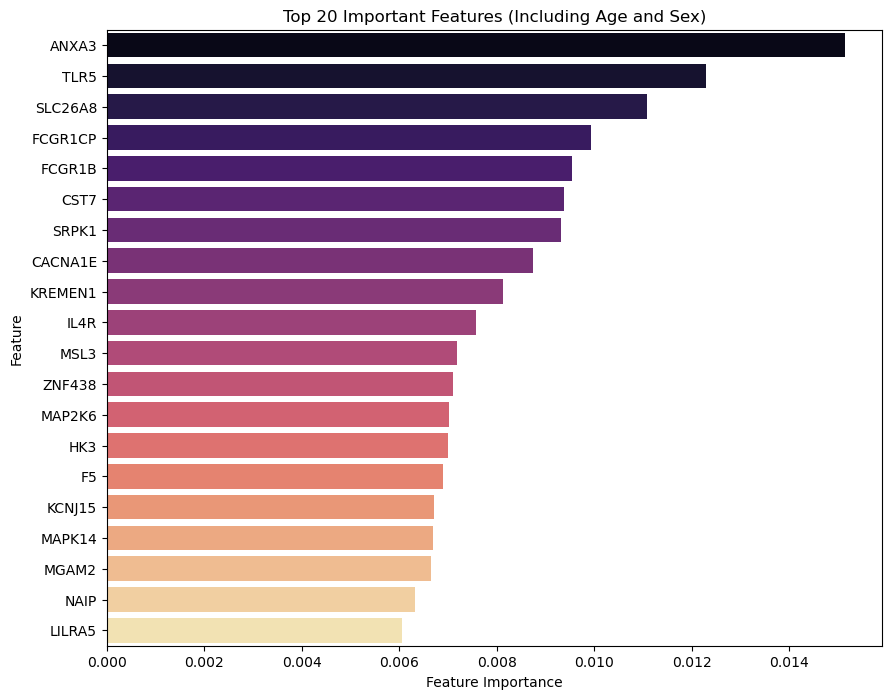

In [26]:
importances_aux = rfc_aux.feature_importances_

feature_importances_aux = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances_aux
})

feature_importances_aux = feature_importances_aux.sort_values('Importance', ascending=False)

top_features_aux = feature_importances_aux.head(20)
print(top_features_aux)

plt.figure(figsize=(10,8))
sns.barplot(x='Importance', y='Feature', data=top_features_aux, palette='magma')
plt.title('Top 20 Important Features (Including Age and Sex)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()


In [27]:
from sklearn.model_selection import cross_val_score

logreg_aux = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=5000)
cv_scores_logreg_aux = cross_val_score(logreg_aux, X_with_aux, y, cv=cv, scoring='accuracy')
print("Logistic Regression with Aux Features CV Accuracy:", cv_scores_logreg_aux.mean())

cv_scores_rfc_aux = cross_val_score(rfc_aux, X_with_aux, y, cv=cv, scoring='accuracy')
print("Random Forest with Aux Features CV Accuracy:", cv_scores_rfc_aux.mean())


Logistic Regression with Aux Features CV Accuracy: 0.6305084745762712
Random Forest with Aux Features CV Accuracy: 0.6423728813559322
